## Seq2seq으로 번역기 만들기
- 데이터 전처리
- 모델 설계
- 훈련하기
- 시각화


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
# matplot은 한국어를 지원하지 않기 때문에 한글로 처리하는 작업
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

### 데이터 준비하기

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os

print(tf.__version__)

2.6.0


In [3]:
# tensforflow에서 제공하는 함수를 사용하여 데이터를 다운로드 받는다
path = os.getenv("HOME") + '/aiffel/korean-parallel-corpora'
print(path)
path_to_en = path +"/korean-english-news-v1/korean-english-park.train.en"
path_to_kr = path +"/korean-english-news-v1/korean-english-park.train.ko"

/aiffel/aiffel/korean-parallel-corpora


In [4]:
# 데이터 형태 읽어오기
with open(path_to_en,'r', encoding='utf-8') as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))
print("Example:")

for sen in raw_en[:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [5]:
# 데이터 형태 읽어오기
with open(path_to_kr,'r', encoding='utf-8') as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print("Example:")

for sen in raw_ko[:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [6]:
df = pd.DataFrame(raw_en, columns = ['EN'])
df['KR'] = np.array(raw_ko)
df

,EN,KR
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...
...,...,...
94118,””We are hoping to seize material evidence to ...,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...
94119,"” On Monday, police secured statements from si...",월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.
94120,But the lack of material evidence is making it...,그러나 불충분한 증거 확보로 수사에 어려움이 있다.
94121,Kim and his son both deny the allegations.,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.


In [7]:
# 중복 데이터 제거하기
cleaned_corpus = df.drop(df[df['EN'].duplicated()].index)
cleaned_corpus.head()

,EN,KR
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...


In [8]:
# 중복 데이터가 제거된 values cleaned corpus에 저장
cleaned_corpus = cleaned_corpus[['EN','KR']].values
cleaned_corpus.shape

(75598, 2)

### Module

In [9]:
# 토큰화
def tokenize(corpus):
    # out of vocabulary에 토큰 처리 - nan 값에 '0'으로 대체했기 때문에 처리한다
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters ='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    # padding을 해주고 maxlen은 문장 최대 길이로 설정했다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen = 25)

    return tensor, tokenizer

In [10]:
# 데이터 전처리 함수 재정의
def preprocessing(sentence, is_english=True, pattern =None):
    sentence = sentence.lower()  # 소문자로 변환
    # 한국어 정규식으로 전처리
    sentence = re.sub(pattern, ' ', sentence) if not is_english else sentence
    
    # konlpy.tag에 Mecab 토크나이저 사용
    # 영어인 경우 공백을 기준으로 토큰화
    sentence = mecab.morphs(sentence) if not is_english else sentence.split()
    
    # 영어인 경우에 start, end 토큰
    if is_english:
        sentence = ['<start>'] + sentence + ['<end>']  # 영어일 경우에만 <start>와 <end> 토큰 추가

    return sentence

In [11]:
# Bahdanau alignment score Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]
        
        #  W * h_enc
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        # W * h_dec
        h_dec = self.w_dec(h_dec)
        
        #  Bahdanau , w_com -> V.T
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # alignment score 값을 확률분포로 만들어준다
        attn = tf.nn.softmax(score, axis=1)
        
        # C = W(attn) * h_encoder
        context_vec = attn * h_enc
        # 출력된 값의 합을 구하면 각 timestep마다 주목해야 할 단어에 강조되는 context vector를 구할 수 있따.
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

    

In [12]:
# GRU 인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [13]:
# GRU 디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.masking = Masking(mask_value=0.0)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = self.masking(out)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [14]:
# 평가
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

# Attention map 시각화
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# 번역
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))




In [15]:
# 손실 함수 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


In [16]:
# train step으로 loss를 계산한 후 반환하는 함수
#@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    # 모든 연산을 기록하는 테이프 , 스텝의 최종 단계에서 미분 값을 구하는데 사용된다
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [17]:
# Test loss 
#@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [32]:
from konlpy.tag import Mecab

mecab = Mecab()

def preprocess_sentence(sentence, is_english=False, s_token=False, e_token=False):
    if is_english:
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
    else:
        sentence = sentence.strip()
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]+", "", sentence)
        sentence = " ".join(mecab.morphs(sentence))

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence


In [18]:
# data load 함수
# 전처리, 토큰화 , train_test_split
cleaned_corpus[0][0]

'Much of personal computing is about "can you top this?"'

### 데이터 준비

In [19]:
from konlpy.tag import Mecab
# 데이터 상위 3만개 사용
num_examples = 30000

# 추가된 한글 정규식 및 Mecab 객체 생성
kr_pattern = re.compile("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]+")
mecab = Mecab()

cleaned_corpus_en = [preprocessing(en[0], is_english=True) for en in cleaned_corpus]
cleaned_corpus_kr = [preprocessing(kr[1], is_english=False, pattern=kr_pattern) for kr in cleaned_corpus]

print(cleaned_corpus_en[0])
print(cleaned_corpus_kr[1])

['<start>', 'much', 'of', 'personal', 'computing', 'is', 'about', '"can', 'you', 'top', 'this?"', '<end>']
['모든', '광', '마우스', '와', '마찬가지', '로', '이', '광', '마우스', '도', '책상', '위', '에', '놓', '는', '마우스', '패드', '를', '필요', '로', '하', '지', '않', '는다']


In [20]:
print(cleaned_corpus_en[1])
print(cleaned_corpus_kr[1])

['<start>', 'so', 'a', 'mention', 'a', 'few', 'weeks', 'ago', 'about', 'a', 'rechargeable', 'wireless', 'optical', 'mouse', 'brought', 'in', 'another', 'rechargeable,', 'wireless', 'mouse.', '<end>']
['모든', '광', '마우스', '와', '마찬가지', '로', '이', '광', '마우스', '도', '책상', '위', '에', '놓', '는', '마우스', '패드', '를', '필요', '로', '하', '지', '않', '는다']


In [21]:
print(len(cleaned_corpus_en))
print(len(cleaned_corpus_kr))

75598
75598


In [22]:
# 토큰 길이가 40 이하인 데이터 선별
eng_corpus = [en for i,(en,kr) in enumerate(zip(cleaned_corpus_en,cleaned_corpus_kr))  if len(kr) < 40]
kor_corpus = [kr for i,(en,kr) in enumerate(zip(cleaned_corpus_en,cleaned_corpus_kr))  if len(kr) < 40]


#eng_corpus_df = pd.DataFrame(cleaned_corpus_en)
#kor_corpus_df = pd.DataFrame(cleaned_corpus_kr)
##kor_corpus_v = kor_corpus_df.drop(pd.DataFrame(kor_corpus).index).fillna('0').values.tolist()
#eng_corpus_v = eng_corpus_df.drop(pd.DataFrame(kor_corpus).index).fillna('0').values.tolist()

In [23]:
# 결과 확인
print("Number of English Sentences:", len(eng_corpus))
print("Number of Korean Sentences:", len(kor_corpus))

Number of English Sentences: 64515
Number of Korean Sentences: 64515


In [24]:
eng_corpus[1]

['<start>',
 'so',
 'a',
 'mention',
 'a',
 'few',
 'weeks',
 'ago',
 'about',
 'a',
 'rechargeable',
 'wireless',
 'optical',
 'mouse',
 'brought',
 'in',
 'another',
 'rechargeable,',
 'wireless',
 'mouse.',
 '<end>']

In [25]:
kor_corpus[1]

['모든',
 '광',
 '마우스',
 '와',
 '마찬가지',
 '로',
 '이',
 '광',
 '마우스',
 '도',
 '책상',
 '위',
 '에',
 '놓',
 '는',
 '마우스',
 '패드',
 '를',
 '필요',
 '로',
 '하',
 '지',
 '않',
 '는다']

### 데이터 전처리 : 토큰화

In [26]:
# Tokenize the preprocessed sentences
enc_tensor, enc_tokenizer =  tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

# Split the data into training and validation sets
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

# Display the shapes of the training and valida|tion sets
print("Encoder Train:", enc_train.shape)
print("Decoder Train:", dec_train.shape)

# You can also display the shapes of the validation sets if needed
print("Encoder Validation:", enc_val.shape)
print("Decoder Validation:", dec_val.shape)


Encoder Train: (51612, 25)
Decoder Train: (51612, 25)
Encoder Validation: (12903, 25)
Decoder Validation: (12903, 25)


In [27]:
print(len(enc_tokenizer.index_word),
len(dec_tokenizer.index_word) + 1)

38177 88643


### 모델 설계

In [28]:
from tensorflow.keras.layers import Masking
# 코드를 실행하세요.
BATCH_SIZE     = 128
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 64
embedding_dim = 256

# GRU Encoder 생성
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
# GRU Decoder 생성
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 25

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
# Encoder Output
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))
# Decoder output - decoder hidden state, attention
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (128, 25, 64)
Decoder Output: (128, 88643)
Decoder Hidden State: (128, 64)
Attention: (128, 25, 1)


### 훈련하기 - Optimizer & Loss

In [29]:
print(dec_train[1])
print(enc_train[1])

[    2   119  1138   172     6 31643  3308     7     1  2598  1127  6134
     3     0     0     0     0     0     0     0     0     0     0     0
     0]
[2265 1701   14    6    5 1252 1774 1668    4  375   19 1358  388    1
    0    0    0    0    0    0    0    0    0    0    0]


In [30]:
from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 101/101 [00:21<00:00,  4.71it/s, Test Loss 5.1134]


### Attention Map

Input: 첫 번 째 로 사망자 가 발생 했 다
Predicted translation: the first time in the first time in the first time in the first time in the first time in the first time in the 


/tmp/ipykernel_47/247148186.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/247148186.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


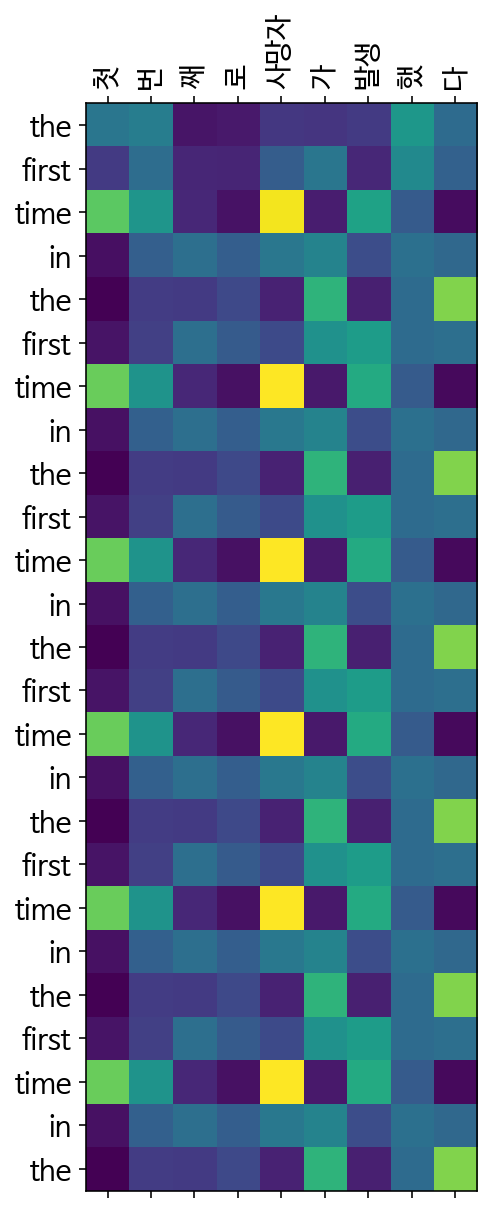

In [36]:
translate("첫 번째로 사망자가 발생했다.", encoder, decoder)